In [1]:
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.integrate import trapz, cumtrapz

import h5py
import os
import sys
import time
from tqdm import tqdm
import itertools

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import gridspec

import astropy.units as u
import astropy.constants as C
from astropy.cosmology import z_at_value
from astropy.cosmology import Planck15 as cosmo

import peters

from IPython.core.debugger import set_trace
from importlib import reload
            
colors = sns.color_palette("colorblind", n_colors=10)

plt.style.use("/Users/michaelzevin/.MATPLOTLIB_RCPARAMS.sty")

### Read in grid of optimal SNRs and detection probabilities

In [2]:
grid_path = '/Users/michaelzevin/research/selection_effects/data/pdet_grid.hdf5'
grid_O3 = pd.read_hdf(grid_path, key='midhighlatelow_network')
grid_design = pd.read_hdf(grid_path, key='design_network')

### VT as function of primary mass and mass ratio

$$ VT(m_1,m_2) = T \int dz \frac{dV_c}{dz} \frac{1}{1+z} f(z,m_1,m_2) $$ 

In [3]:
def VT_integrand(cut_grid):
    z_vals = np.asarray(cut_grid['z'])
    pdet_vals = np.asarray(cut_grid['pdet'])
    integrand = cosmo.differential_comoving_volume(z_vals) * (1+z_vals)**-1 * pdet_vals
    return integrand

def VT_at_given_m1_q(grid, m1_fixed, q_fixed, T=1*u.yr):
    cut_grid = grid.loc[(grid['m1']==m1_fixed) & (grid['q']==q_fixed)]
    integrand = VT_integrand(cut_grid)
    VT = T * trapz(integrand, np.asarray(cut_grid['z']))
    return VT.to(u.Gpc**3 * u.yr / u.sr)

Text(0.05, 0.85, '$VT \\propto m_1^{2.0}$')

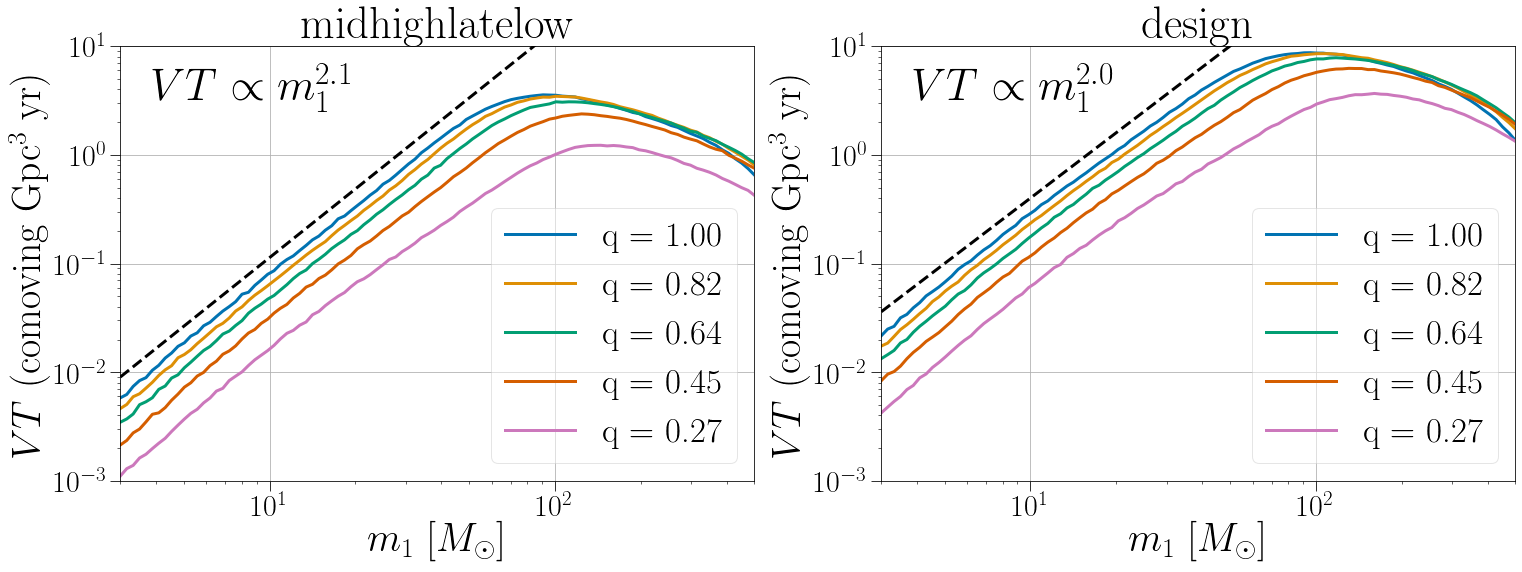

In [4]:
fig, axs = plt.subplots(1,2, figsize=(25,8))

for ax, grid, name in zip(axs, [grid_O3, grid_design], ['midhighlatelow', 'design']):
    for idx, q in enumerate(grid.q.unique()[::-1][::20]):

        VT_across_m1 = []
        m1_vals = grid.m1.unique()
        for m1 in m1_vals:
            VT_across_m1.append(VT_at_given_m1_q(grid, m1, q, T=1*u.yr).value)

        ax.plot(m1_vals, VT_across_m1, color=colors[idx], label='q = {:0.2f}'.format(q))
    
    ax.set_xlabel(r'$m_1\ [M_\odot]$')
    ax.set_ylabel('$VT$ (comoving Gpc$^{3}$ yr)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(3,500)
    ax.set_ylim(1e-3,1e1)
    ax.set_title(name)
    ax.legend()
    
# plot scaling relation
xvals = np.linspace(3, 500, 1000)
# midhighlatelow
alpha=2.1
yvals = xvals**alpha
axs[0].plot(xvals, 0.0009*yvals, color='k', linestyle='--')
axs[0].annotate(r'$VT \propto m_1^{%0.1f}$' % alpha, (0.05,0.85), xycoords='axes fraction', fontsize=45)
# design
alpha=2.0
yvals = xvals**alpha
axs[1].plot(xvals, 0.004*yvals, color='k', linestyle='--')
axs[1].annotate(r'$VT \propto m_1^{%0.1f}$' % alpha, (0.05,0.85), xycoords='axes fraction', fontsize=45)

### Comoving volume versus Eucliedean volume

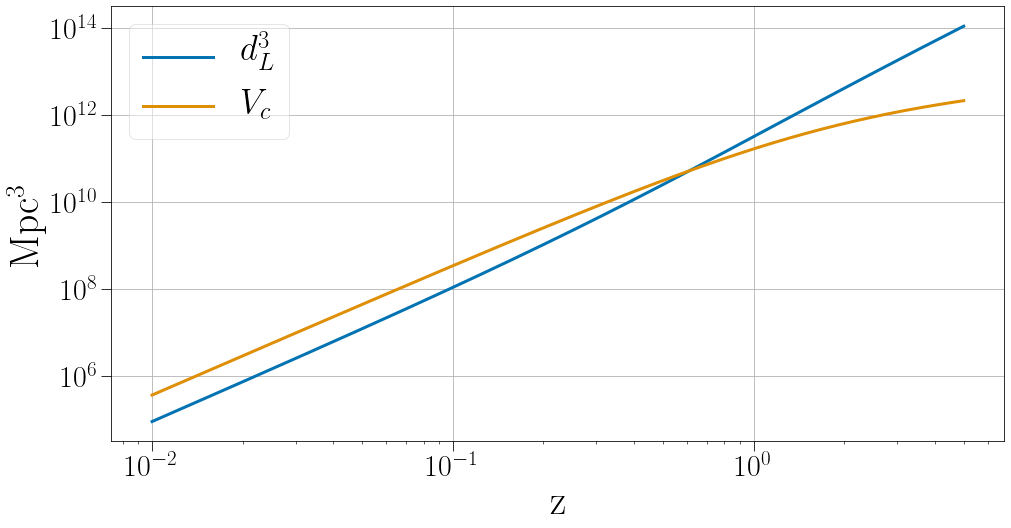

In [5]:
z_vals = np.logspace(np.log10(0.01),np.log10(5),1000)
dL3 = cosmo.luminosity_distance(z_vals)**3
Vc = cosmo.comoving_volume(z_vals)

fig, axs = plt.subplots(figsize=(16,8))

axs.plot(z_vals, dL3, color=colors[0], label=r'$d_L^3$')
axs.plot(z_vals, Vc, color=colors[1], label=r'$V_c$')
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlabel('z')
axs.set_ylabel('Mpc$^3$')
axs.legend()

### Optimal SNR and detection probability at fixed redshift

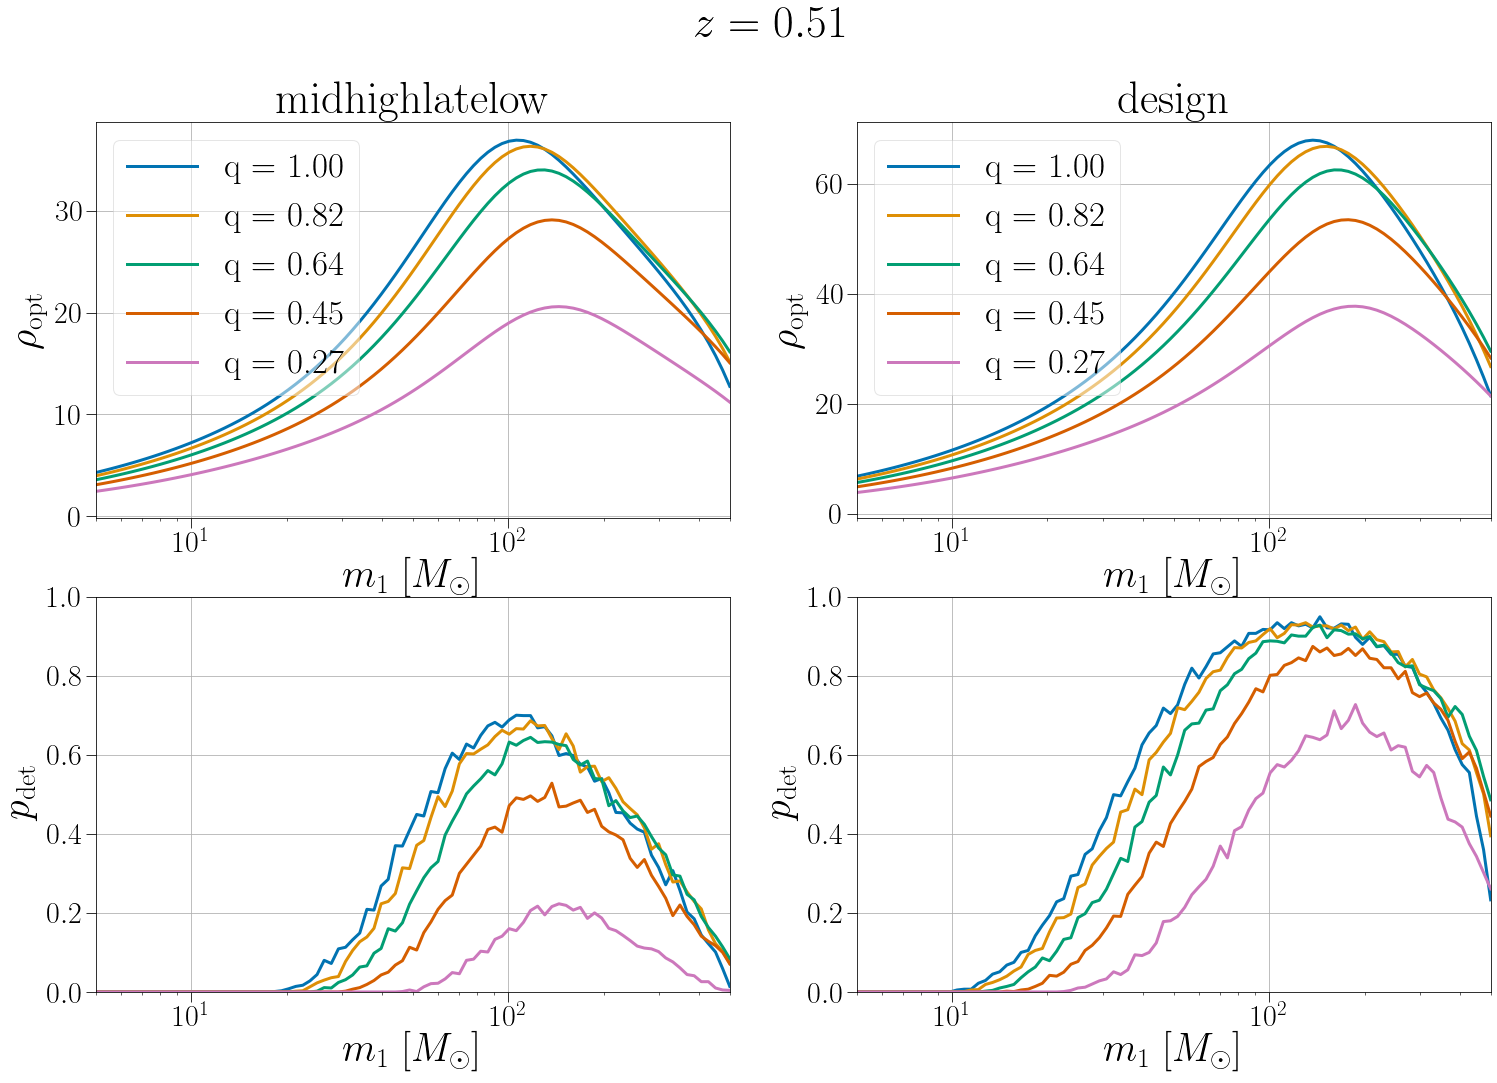

In [6]:
z_fixed = grid.z.unique()[30]

fig, axs = plt.subplots(2,2, figsize=(25,16))

for subaxs, grid, name in zip(axs.T, [grid_O3, grid_design], ['midhighlatelow', 'design']):

    for idx, q_fixed in enumerate(grid['q'].unique()[::-1][::20]):
        grid_cut = grid.loc[(grid['q'] == q_fixed) & (grid['z']==z_fixed)]

        subaxs[0].plot(grid_cut['m1'], grid_cut['snr_opt'], color=colors[idx], label='q = {:0.2f}'.format(q_fixed))
        subaxs[1].plot(grid_cut['m1'], grid_cut['pdet'], color=colors[idx], label='q = {:0.2f}'.format(q_fixed))

    subaxs[0].legend()

    fig.suptitle(r'$z = {:0.2f}$'.format(z_fixed))

    for ax in subaxs:
        ax.set_xlabel(r'$m_1\ [M_\odot]$')
        ax.set_xlim(5,500)
        ax.set_xscale('log')
    
    subaxs[0].set_title(name)
    subaxs[0].set_ylabel(r'$\rho_\mathrm{opt}$')
    subaxs[1].set_ylabel(r'$p_\mathrm{det}$')
    subaxs[1].set_ylim(0,1)


### 2D Mtot/q heat maps of optimal SNR and detection probability at a fixed redshift

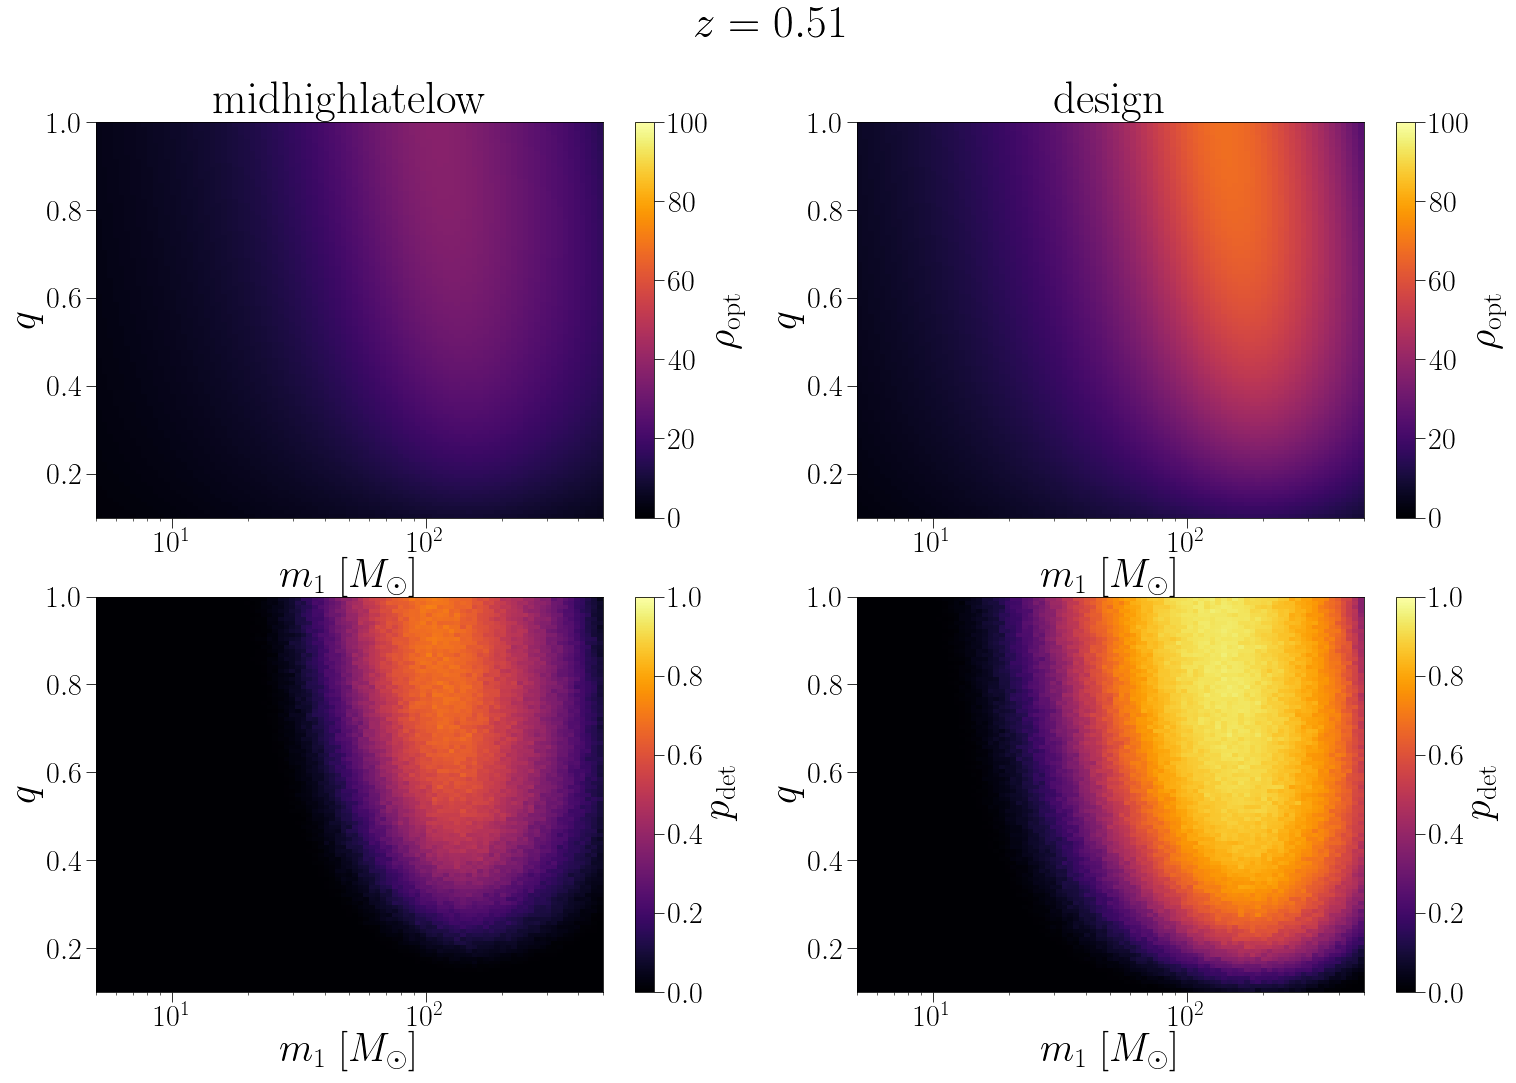

In [7]:
z_fixed = grid.z.unique()[30]

fig, axs = plt.subplots(2,2, figsize=(25,16))

for subaxs, grid, name in zip(axs.T, [grid_O3, grid_design], ['midhighlatelow', 'design']):
    
    grid_cut = grid.loc[(grid['z']==z_fixed)]

    snr_opts = np.asarray(grid_cut.snr_opt).reshape((100,100)).T
    pdets = np.asarray(grid_cut.pdet).reshape((100,100)).T
    m1s = np.asarray((grid_cut['m1']).unique())
    qs = np.asarray((grid_cut['q']).unique())

    col0 = subaxs[0].pcolormesh(m1s, qs, snr_opts, vmin=0, vmax=100, cmap='inferno')
    col1 = subaxs[1].pcolormesh(m1s, qs, pdets, vmin=0, vmax=1, cmap='inferno')

    cax0 = fig.colorbar(col0, ax=subaxs[0])
    cax1 = fig.colorbar(col1, ax=subaxs[1])
    cax0.set_label(r'$\rho_\mathrm{opt}$')
    cax1.set_label(r'$p_\mathrm{det}$')

    fig.suptitle(r'$z = {:0.2f}$'.format(z_fixed))
    subaxs[0].set_title(name)

    for ax in subaxs:
        ax.set_xlabel(r'$m_1\ [M_\odot]$')
        ax.set_xlim(5,500)
        ax.set_xscale('log')
        ax.set_ylabel(r'$q$')
        ax.set_ylim(0.1,1)


### Create generic selection function in m1, q, z

In [8]:
from sklearn.neighbors import KNeighborsRegressor

def normalize(x, xmin, xmax, a=0, b=1):
    # normalizes data on range [a,b]
    data_norm = (b-a)*(x-xmin) / (xmax-xmin) + a
    return data_norm

def denormalize(normx, xmin, xmax, a=0, b=1):
    data = (normx-a)*(xmax-xmin) / (b-a) + xmin
    return data

In [9]:
def selection_function(data, grid, pdet_only=False, **kwargs):
    """
    Gives a relative weight to each system in the dataframe `df` based on its proximity
    to the points on the grid. 
    
    Each system in `df` should have a primary mass `m1`, secondary mass `m2`, and redshift `z`
    
    This function will find the nearest Euclidean neighbor in [log(m1), q, z] space
    
    Need to specify bounds (based on the trained grid) so that the grid and data get normalized properly
    """
    # get values from grid for training
    m1_grid = np.asarray(grid['m1'])
    q_grid = np.asarray(grid['q'])
    z_grid = np.asarray(grid['z'])
    pdets = np.asarray(grid['pdet'])
    
    # get bounds based on grid
    m1_bounds = (np.round(m1_grid.min(), 2), np.round(m1_grid.max(), 2))
    q_bounds = (np.round(q_grid.min(), 2), np.round(q_grid.max(), 2))
    z_bounds = (np.round(z_grid.min(), 2), np.round(z_grid.max(), 2))
    
    # normalize to unit cube
    logm1_grid_norm = normalize(np.log10(m1_grid), np.log10(m1_bounds[0]), np.log10(m1_bounds[1]))
    q_grid_norm = normalize(q_grid, q_bounds[0], q_bounds[1])
    z_grid_norm = normalize(z_grid, z_bounds[0], z_bounds[1])
    
    # train nearest neighbor algorithm
    X = np.transpose(np.vstack([logm1_grid_norm, q_grid_norm, z_grid_norm]))
    y = np.transpose(np.atleast_2d(pdets))
    nbrs = KNeighborsRegressor(n_neighbors=10, weights='distance', algorithm='ball_tree', leaf_size=30, p=2, metric='minkowski')
    nbrs.fit(X, y)
    
    # get values from dataset and normalize
    m1_data = np.asarray(data['m1'])
    q_data = np.asarray(data['q'])
    z_data = np.asarray(data['z'])
    logm1_data_norm = normalize(np.log10(m1_data), np.log10(m1_bounds[0]), np.log10(m1_bounds[1]))
    q_data_norm = normalize(q_data, q_bounds[0], q_bounds[1])
    z_data_norm = normalize(z_data, z_bounds[0], z_bounds[1])
    
    # values that are not between [0,1] are outside the bounds; don't try to fit these!
    #pdets = np.zeros(len(data))
    #valid_idxs = np.squeeze(np.argwhere((logm1_data_norm >= 0) & (logm1_data_norm <= 1) & \
    #                        (q_data_norm >= 0) & (q_data_norm <= 1) & (z_data_norm >= 0) & (z_data_norm <= 1)))
    
    # get pdets for the testing data
    X_fit = np.transpose(np.vstack([logm1_data_norm, q_data_norm, z_data_norm]))
    y_fit = nbrs.predict(X_fit).flatten()
    assert all([((y<=1) & (y>=0)) for y in y_fit]), 'pdet is not between 0 and 1'

    
    if pdet_only==True:
        return y_fit
    else:
        # cosmological VT term for fitted data
        if 'cosmo' in kwargs:
            cosmo = kwargs['cosmo']
        else:
            cosmo = astropy.cosmology.Planck15
        cosmo_weight = cosmo.differential_comoving_volume(z_data) * (1+z_data)**(-1.0)
        combined_weight = y_fit * cosmo_weight
        combined_weight /= np.sum(combined_weight)
        return combined_weight
    

In [10]:
# test this

rand_idxs = np.random.choice(np.arange(len(grid_design)), size=int(0.99*len(grid_design)), replace=False)
df_train = grid_design.iloc[rand_idxs]
df_test = grid_design.drop(rand_idxs)

pdets = selection_function(df_test, df_train, pdet_only=True)

Text(0, 0.5, 'N')

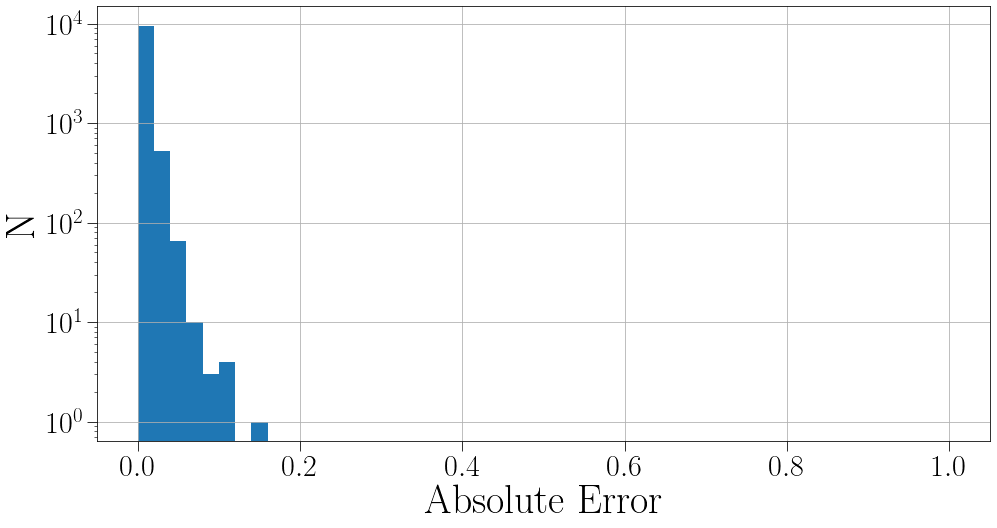

In [11]:
fig, axs = plt.subplots(figsize=(16,8))
_ = axs.hist(np.abs(pdets - np.asarray(df_test['pdet'])), bins=50, range=(0,1))
axs.set_yscale('log')
axs.set_xlabel('Absolute Error')
axs.set_ylabel('N')